# TP4: Primeras nociones de estimación espectral. #


El trabajo abarca la evaluación de distintos estimadores de frecuencia y amplitud para una señal senoidal sumada a un ruido blanco gaussiano. Se estudió el efecto de la aplicación de 3 ventanas (Rectangular, Blackman-Harris y Flat Top) en el sesgo y varianza de los estimadores para valores distintas relaciones señal-ruido.


Se utilizó una señal:
$ x(n) = a1 * sen(\Omega_1 n ) + n_a (n) $

La potencia de la senoidal fue normalizada a 1 W para calibrar correctamente el SNR.

## Método: ##

Se llevaron a cabo 200 realzaciones de señales, para cada una de las cuales se tomaron 1000 muestras. Para cada una se calcularon los valores de los estimadores de $\hat{a}1^{(i)}$ y $\hat{\Omega}_1^{(i)} $. Utilizando:

$ $\hat{a}1^{(i)}$ = |X_i^w(\Omega_0)| =| \mathcal{F}{ x(n) w_i(n) }|$

$ \hat{\Omega}_1^{(i)} = \arg\max_{\Omega}{|X_i^w(\Omega)|} $

Es decir que el estimador de amplitud  $\hat{a}1^{(i)}$  se obtiene como el valor absoluto de la transformada del producto de la función x(n) y la ventada elegida. 
En cuanto al estimador de frecuencia $ \hat{\Omega}_1^{(i)} $, se obtiene como el argumento máximo del valor absoluto de la transformada de la señal. Es decir, el valor de entrada para el cuál la salida alcanza un máximo.
Para ello, se implementó el siguiente código:

### Resultados para SNR = 10 ###

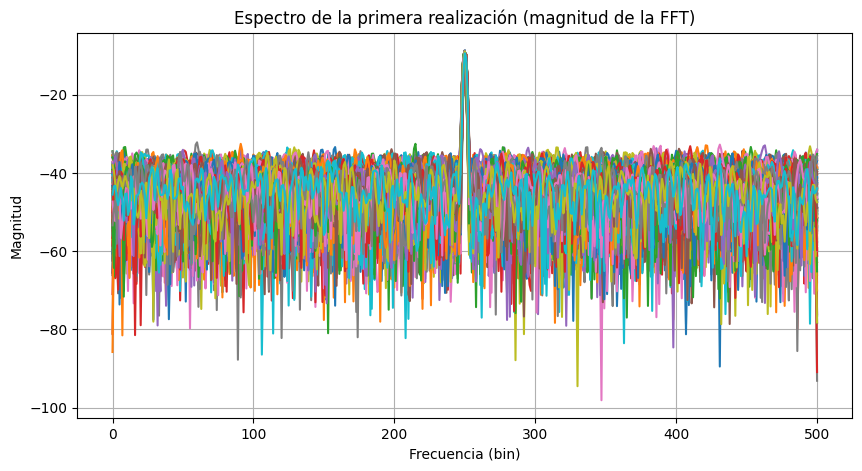

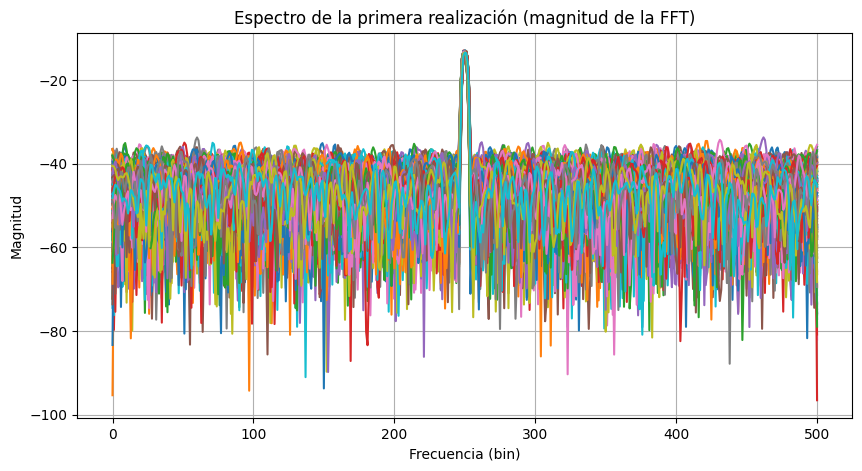

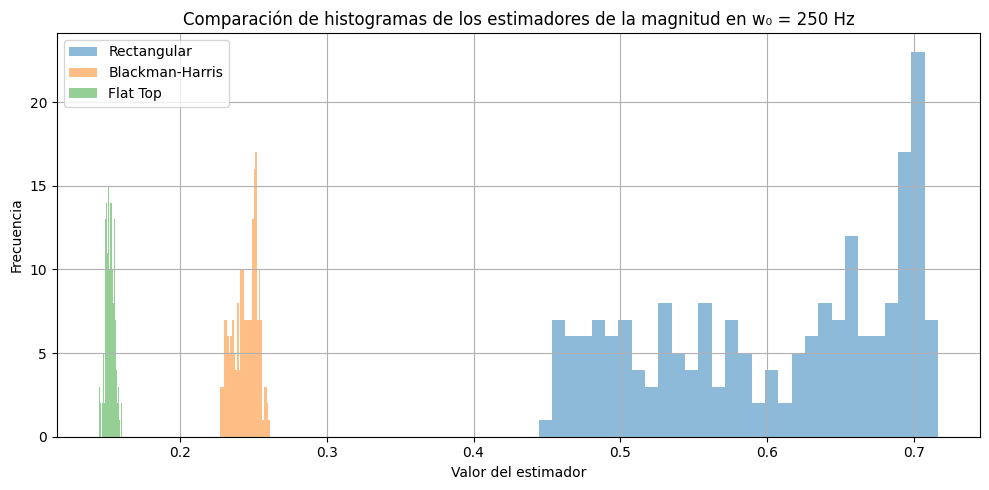

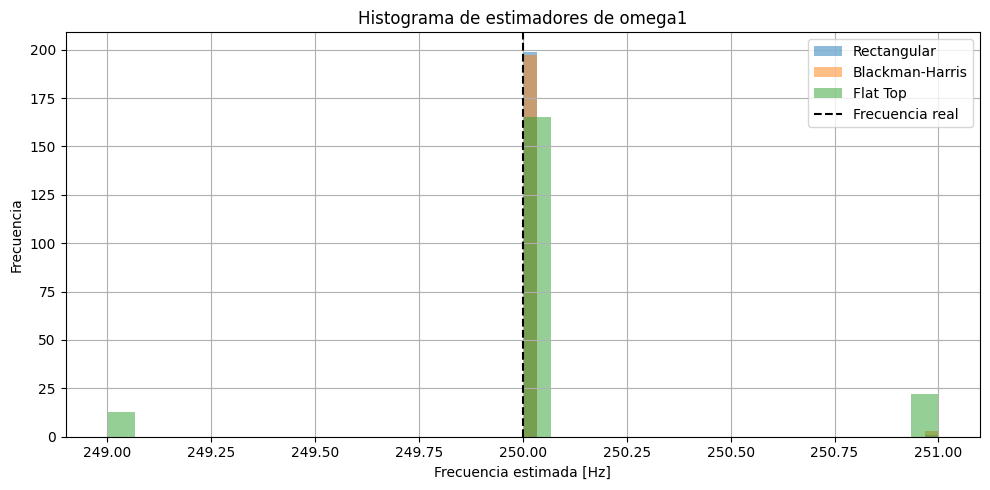

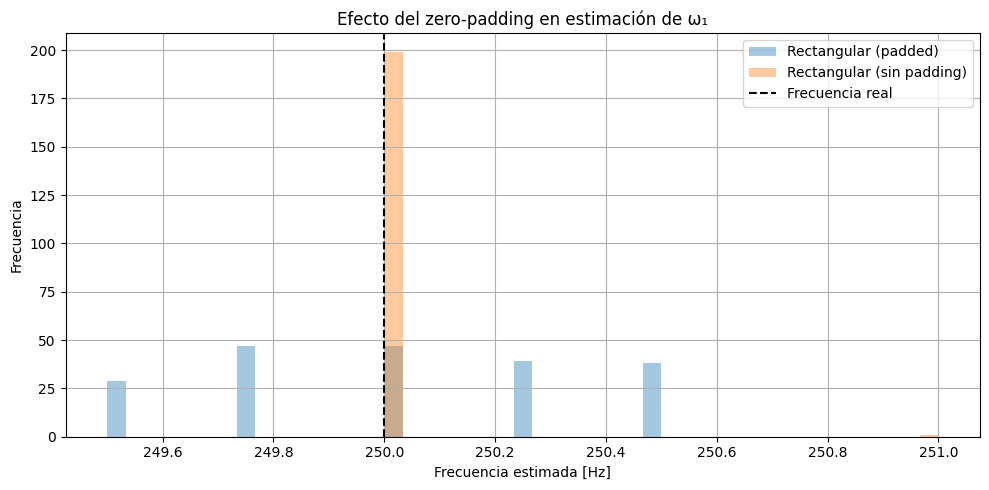

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

#%% Función para generar la señal seno
def seno(N, R, SNR):
    
    N=1000
    fs=1000
    df= fs/N
    w0 = fs/4
    a1=np.sqrt(2)
    R=200
    

    t = np.arange(0,1,1/N).reshape(N, 1)
    tt=np.tile(t, (1,R))#repite tt 200 veces en el eje de las columnas


    fr = np.random.uniform(-1/2, 1/2, size=(1, R))
    w1 = w0 + fr * df

    S = a1*np.sin(2*np.pi*w1*tt) #1000 * 200
    
    potseñal = np.mean(S**2)
    potruido = potseñal / (10**(SNR/10))
    

    ruido=np.random.normal(0, np.sqrt(potruido), size=S.shape)
    
    Xr = S + ruido #genera 200 señales con ruido
    
    return Xr, w1

#%%señales
Xr, w1 = seno(N=1000, R=200, SNR=10)
fs = 1000
N=1000
df=fs/N
ff = np.linspace(0, (N-1)*df, N)
bfrec = ff <= fs/2 #hasta nyquist, por la simetría de la fft, lo demás es redundante.
w0 = fs/4
a1= np.sqrt(2)

Xr_fft = np.fft.fft(Xr, axis=0)
MAG_Xr_fft = 1/N * np.abs(Xr_fft)

    
#%% VENTANAS



ventana2=sig.windows.blackmanharris(N).reshape(N,1)
senal_BH = Xr * ventana2 #1000X200

senal_BH_fft= np.fft.fft(senal_BH,axis=0)
MAGsenal_BH_fft = 1/N * np.abs(senal_BH_fft) 

ventana=sig.windows.flattop(N).reshape(N,1)
senal_FT = Xr * ventana #1000X200

senal_FT_fft= np.fft.fft(senal_FT,axis=0)
MAGsenal_FT_fft = 1/N * np.abs(senal_FT_fft) 

plt.figure(figsize=(10, 5))  # Ajustar tamaño del gráfic

plt.plot(ff[bfrec], 10* np.log10(2*(MAGsenal_BH_fft[bfrec,:])**2))
plt.title("Espectro de la primera realización (magnitud de la FFT)")
plt.xlabel("Frecuencia (bin)")
plt.ylabel("Magnitud")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))

plt.plot(ff[bfrec], 10* np.log10(2*(MAGsenal_FT_fft[bfrec,:])**2))
plt.title("Espectro de la primera realización (magnitud de la FFT)")
plt.xlabel("Frecuencia (bin)")
plt.ylabel("Magnitud")
plt.grid(True)
plt.show()

aest_BH =  MAGsenal_BH_fft[round(w0)]
aest_FT = MAGsenal_FT_fft[round(w0)]
aest_rect = MAG_Xr_fft[round(w0)]

#############
# Histograma
#############

plt.figure(figsize=(10,5))
bins = 30
plt.hist(aest_rect, bins=bins, alpha=0.5, label="Rectangular")
plt.hist(aest_BH, bins=bins, alpha=0.5, label="Blackman-Harris")
plt.hist(aest_FT, bins=bins, alpha=0.5, label="Flat Top")

plt.xlabel("Valor del estimador")
plt.ylabel("Frecuencia")
plt.title("Comparación de histogramas de los estimadores de la magnitud en w₀ = 250 Hz")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#%% Calculo de sesgo

sesgo_BH = np.mean(aest_BH)- a1
sesgo_FT = np.mean(aest_FT)- a1
sesgo_RECT = np.mean(aest_rect)-a1

var_BH = np.var(aest_BH)
var_FT =np.var(aest_FT)
var_RECT = np.var(aest_rect)


#%%

# ARGMAX= punto de entrada donde se maximiza la salida
# el estimador omegahat de omega1 es la entrada donde Xw alcanza un max
R=200
fs = 1000
N=1000
df=fs/N

kmax_BH = np.argmax(MAGsenal_BH_fft)
kmax_FT = np.argmax(MAGsenal_FT_fft)
kmax_RECT = np.argmax(MAG_Xr_fft)

omega1est_BH = np.zeros(R)
omega1est_FT = np.zeros(R)
omega1est_RECT = np.zeros(R) #3 vectores de 200 elementos inicializados en 0

for i in range(R):
    kmax_BH = np.argmax(MAGsenal_BH_fft[:N//2, i])  # hasta Nyquist
    kmax_FT = np.argmax(MAGsenal_FT_fft[:N//2, i])
    kmax_RECT = np.argmax(MAG_Xr_fft[:N//2, i])

    omega1est_BH[i] = kmax_BH * df
    omega1est_FT[i] = kmax_FT * df
    omega1est_RECT[i] = kmax_RECT * df

plt.figure(figsize=(10, 5))
plt.hist(omega1est_RECT, bins=30, alpha=0.5, label='Rectangular')
plt.hist(omega1est_BH, bins=30, alpha=0.5, label='Blackman-Harris')
plt.hist(omega1est_FT, bins=30, alpha=0.5, label='Flat Top')
plt.axvline(w0, color='k', linestyle='--', label='Frecuencia real')
plt.xlabel('Frecuencia estimada [Hz]')
plt.ylabel('Frecuencia')
plt.title('Histograma de estimadores de omega1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

sesgo_w_BH = np.mean(omega1est_BH) - w0
sesgo_w_FT = np.mean(omega1est_FT) - w0
sesgo_w_RECT = np.mean(omega1est_RECT) - w0

var_w_BH = np.var(omega1est_BH)
var_w_FT = np.var(omega1est_FT)
var_w_RECT = np.var(omega1est_RECT)

#%% ZERO padding
fs=1000
Npad = 4000
R = 200
senal_BH_pad = np.zeros((Npad, R))
senal_FT_pad = np.zeros((Npad, R))
Xrpad = np.zeros((Npad, R))

senal_BH_pad[:N, :] = senal_BH #copio la senal original en las primeras N filas e todas las columnas
senal_FT_pad[:N, :] = senal_FT
Xrpad[:N, :] = Xr

BH_fft_pad = np.fft.fft(senal_BH_pad, axis=0)
FT_fft_pad = np.fft.fft(senal_FT_pad, axis=0)
RECT_fft_pad = np.fft.fft(Xrpad, axis=0)

MAG_BH_pad = 1/N * np.abs(BH_fft_pad)
MAG_FT_pad = 1/N * np.abs(FT_fft_pad)
MAG_RECT_pad = 1/N * np.abs(RECT_fft_pad)

dfpad = fs / Npad
ffpad = np.linspace(0, fs - dfpad, Npad)

omega1est_BH_pad = np.zeros(R)
omega1est_FT_pad = np.zeros(R)
omega1est_RECT_pad = np.zeros(R)

for i in range(R):
    kmax_BH_pad = np.argmax(MAG_BH_pad[:Npad//2, i])
    kmax_FT_pad = np.argmax(MAG_FT_pad[:Npad//2, i])
    kmax_RECT_pad = np.argmax(MAG_RECT_pad[:Npad//2, i])

    omega1est_BH_pad[i] = kmax_BH_pad * dfpad
    omega1est_FT_pad[i] = kmax_FT_pad * dfpad
    omega1est_RECT_pad[i] = kmax_RECT_pad * dfpad

plt.figure(figsize=(10, 5))
plt.hist(omega1est_RECT_pad, bins=30, alpha=0.4, label='Rectangular (padded)')
plt.hist(omega1est_RECT, bins=30, alpha=0.4, label='Rectangular (sin padding)')
plt.axvline(w0, color='k', linestyle='--', label='Frecuencia real')
plt.xlabel('Frecuencia estimada [Hz]')
plt.ylabel('Frecuencia')
plt.title('Efecto del zero-padding en estimación de Omega1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Histograma a1: 
Discutir: sesgo mayor paraflattop, con muy baja varianza. sesgo un poco menor para BH con una varianza un poco mayor. Sesgo menor para rectangular y varianza alta. Discutir esto, relacionar con el tamaño del lobulo principal, desparramos de enrgía (?) Relacionar con lo que queremos en la práctica, (sesgo alto se corrige facilmente haciendo el corrimeinto, la varianza no)

Histograma w1: discutir efecto zero padding, revisar que significan estos graficos.

### Resultados para SNR = 3 ###

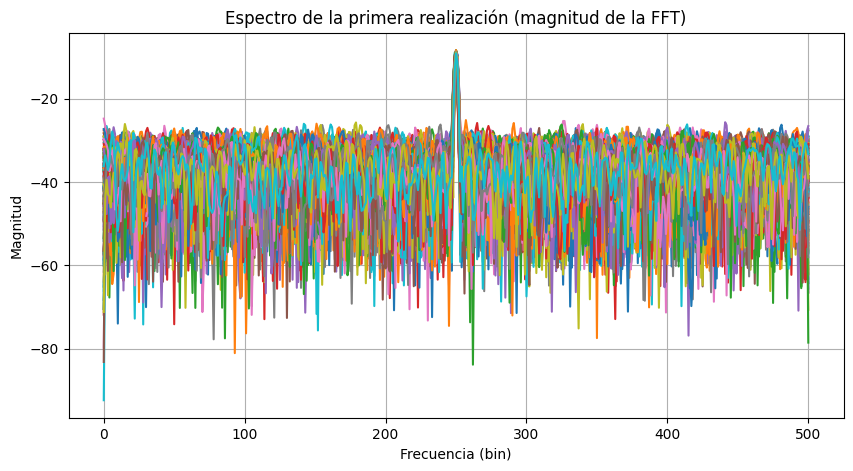

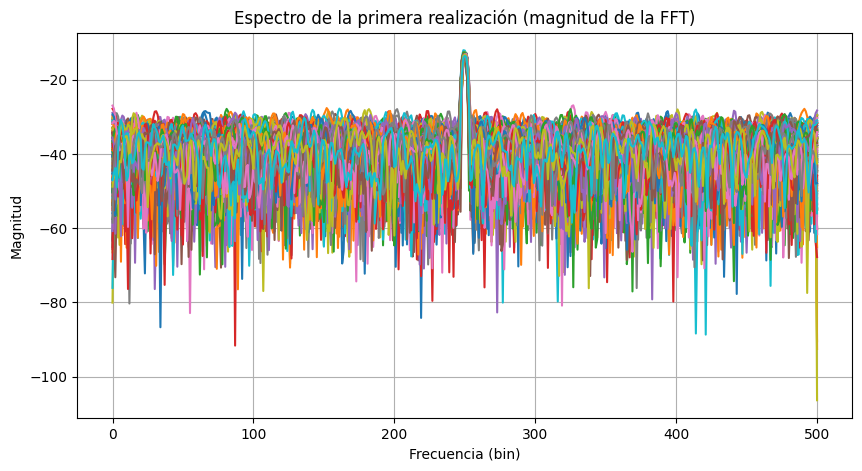

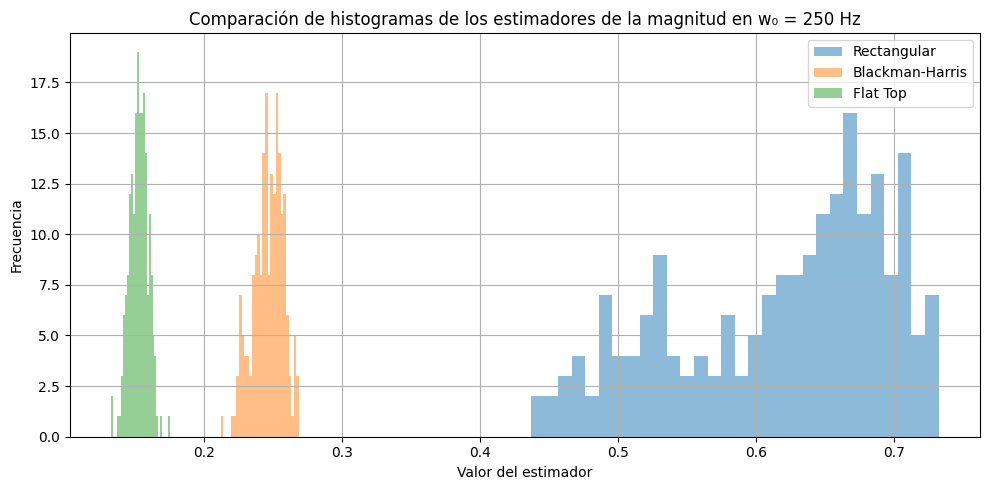

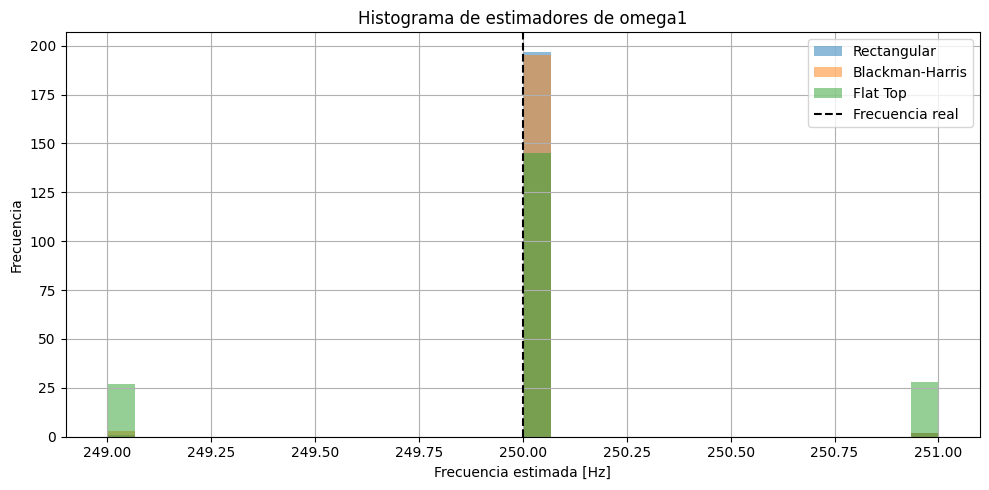

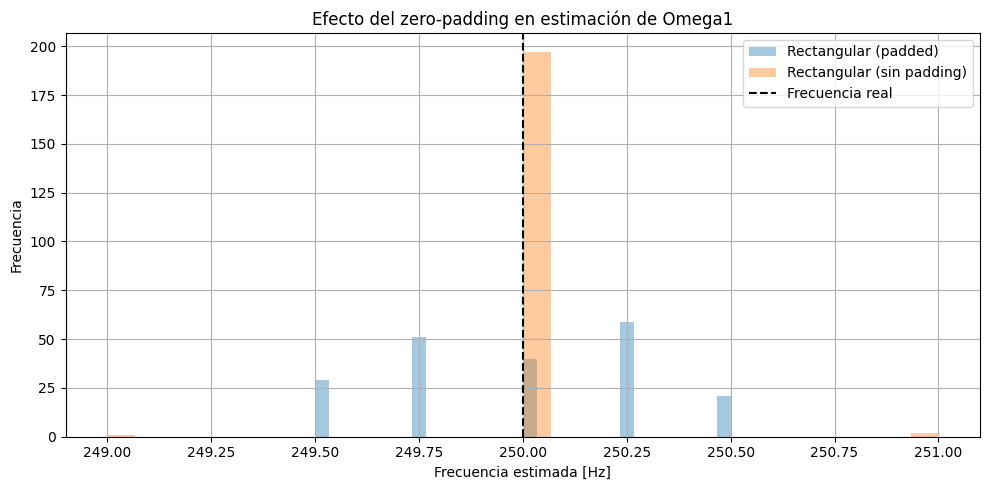

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

#%% Función para generar la señal seno
def seno(N, R, SNR):
    
    N=1000
    fs=1000
    df= fs/N
    w0 = fs/4
    a1=np.sqrt(2)
    R=200
    

    t = np.arange(0,1,1/N).reshape(N, 1)
    tt=np.tile(t, (1,R))#repite tt 200 veces en el eje de las columnas


    fr = np.random.uniform(-1/2, 1/2, size=(1, R))
    w1 = w0 + fr * df

    S = a1*np.sin(2*np.pi*w1*tt) #1000 * 200
    
    potseñal = np.mean(S**2)
    potruido = potseñal / (10**(SNR/10))
    

    ruido=np.random.normal(0, np.sqrt(potruido), size=S.shape)
    
    Xr = S + ruido #genera 200 señales con ruido
    
    return Xr, w1

#%%señales
Xr, w1 = seno(N=1000, R=200, SNR=3)
fs = 1000
N=1000
df=fs/N
ff = np.linspace(0, (N-1)*df, N)
bfrec = ff <= fs/2 #hasta nyquist, por la simetría de la fft, lo demás es redundante.
w0 = fs/4
a1= np.sqrt(2)

Xr_fft = np.fft.fft(Xr, axis=0)
MAG_Xr_fft = 1/N * np.abs(Xr_fft)

    
#%% VENTANAS



ventana2=sig.windows.blackmanharris(N).reshape(N,1)
senal_BH = Xr * ventana2 #1000X200

senal_BH_fft= np.fft.fft(senal_BH,axis=0)
MAGsenal_BH_fft = 1/N * np.abs(senal_BH_fft) 

ventana=sig.windows.flattop(N).reshape(N,1)
senal_FT = Xr * ventana #1000X200

senal_FT_fft= np.fft.fft(senal_FT,axis=0)
MAGsenal_FT_fft = 1/N * np.abs(senal_FT_fft) 

plt.figure(figsize=(10, 5))  # Ajustar tamaño del gráfic

plt.plot(ff[bfrec], 10* np.log10(2*(MAGsenal_BH_fft[bfrec,:])**2))
plt.title("Espectro de la primera realización (magnitud de la FFT)")
plt.xlabel("Frecuencia (bin)")
plt.ylabel("Magnitud")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))

plt.plot(ff[bfrec], 10* np.log10(2*(MAGsenal_FT_fft[bfrec,:])**2))
plt.title("Espectro de la primera realización (magnitud de la FFT)")
plt.xlabel("Frecuencia (bin)")
plt.ylabel("Magnitud")
plt.grid(True)
plt.show()

aest_BH =  MAGsenal_BH_fft[round(w0)]
aest_FT = MAGsenal_FT_fft[round(w0)]
aest_rect = MAG_Xr_fft[round(w0)]

#############
# Histograma
#############

plt.figure(figsize=(10,5))
bins = 30
plt.hist(aest_rect, bins=bins, alpha=0.5, label="Rectangular")
plt.hist(aest_BH, bins=bins, alpha=0.5, label="Blackman-Harris")
plt.hist(aest_FT, bins=bins, alpha=0.5, label="Flat Top")

plt.xlabel("Valor del estimador")
plt.ylabel("Frecuencia")
plt.title("Comparación de histogramas de los estimadores de la magnitud en w₀ = 250 Hz")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#%% Calculo de sesgo

sesgo_BH = np.mean(aest_BH)- a1
sesgo_FT = np.mean(aest_FT)- a1
sesgo_RECT = np.mean(aest_rect)-a1

var_BH = np.var(aest_BH)
var_FT =np.var(aest_FT)
var_RECT = np.var(aest_rect)


#%%

# ARGMAX= punto de entrada donde se maximiza la salida
# el estimador omegahat de omega1 es la entrada donde Xw alcanza un max
R=200
fs = 1000
N=1000
df=fs/N

kmax_BH = np.argmax(MAGsenal_BH_fft)
kmax_FT = np.argmax(MAGsenal_FT_fft)
kmax_RECT = np.argmax(MAG_Xr_fft)

omega1est_BH = np.zeros(R)
omega1est_FT = np.zeros(R)
omega1est_RECT = np.zeros(R) #3 vectores de 200 elementos inicializados en 0

for i in range(R):
    kmax_BH = np.argmax(MAGsenal_BH_fft[:N//2, i])  # hasta Nyquist
    kmax_FT = np.argmax(MAGsenal_FT_fft[:N//2, i])
    kmax_RECT = np.argmax(MAG_Xr_fft[:N//2, i])

    omega1est_BH[i] = kmax_BH * df
    omega1est_FT[i] = kmax_FT * df
    omega1est_RECT[i] = kmax_RECT * df

plt.figure(figsize=(10, 5))
plt.hist(omega1est_RECT, bins=30, alpha=0.5, label='Rectangular')
plt.hist(omega1est_BH, bins=30, alpha=0.5, label='Blackman-Harris')
plt.hist(omega1est_FT, bins=30, alpha=0.5, label='Flat Top')
plt.axvline(w0, color='k', linestyle='--', label='Frecuencia real')
plt.xlabel('Frecuencia estimada [Hz]')
plt.ylabel('Frecuencia')
plt.title('Histograma de estimadores de omega1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

sesgo_w_BH = np.mean(omega1est_BH) - w0
sesgo_w_FT = np.mean(omega1est_FT) - w0
sesgo_w_RECT = np.mean(omega1est_RECT) - w0

var_w_BH = np.var(omega1est_BH)
var_w_FT = np.var(omega1est_FT)
var_w_RECT = np.var(omega1est_RECT)

#%% ZERO padding
fs=1000
Npad = 4000
R = 200
senal_BH_pad = np.zeros((Npad, R))
senal_FT_pad = np.zeros((Npad, R))
Xrpad = np.zeros((Npad, R))

senal_BH_pad[:N, :] = senal_BH #copio la senal original en las primeras N filas e todas las columnas
senal_FT_pad[:N, :] = senal_FT
Xrpad[:N, :] = Xr
#Produce matriz de 4000 * 200 con ceros a partir de N=1000 

BH_fft_pad = np.fft.fft(senal_BH_pad, axis=0)
FT_fft_pad = np.fft.fft(senal_FT_pad, axis=0)
RECT_fft_pad = np.fft.fft(Xrpad, axis=0)

MAG_BH_pad = 1/N * np.abs(BH_fft_pad)
MAG_FT_pad = 1/N * np.abs(FT_fft_pad)
MAG_RECT_pad = 1/N * np.abs(RECT_fft_pad)

dfpad = fs / Npad
ffpad = np.linspace(0, fs - dfpad, Npad)

omega1est_BH_pad = np.zeros(R)
omega1est_FT_pad = np.zeros(R)
omega1est_RECT_pad = np.zeros(R)

for i in range(R):
    kmax_BH_pad = np.argmax(MAG_BH_pad[:Npad//2, i])
    kmax_FT_pad = np.argmax(MAG_FT_pad[:Npad//2, i])
    kmax_RECT_pad = np.argmax(MAG_RECT_pad[:Npad//2, i])

    omega1est_BH_pad[i] = kmax_BH_pad * dfpad
    omega1est_FT_pad[i] = kmax_FT_pad * dfpad
    omega1est_RECT_pad[i] = kmax_RECT_pad * dfpad

plt.figure(figsize=(10, 5))
plt.hist(omega1est_RECT_pad, bins=30, alpha=0.4, label='Rectangular (padded)')
plt.hist(omega1est_RECT, bins=30, alpha=0.4, label='Rectangular (sin padding)')
plt.axvline(w0, color='k', linestyle='--', label='Frecuencia real')
plt.xlabel('Frecuencia estimada [Hz]')
plt.ylabel('Frecuencia')
plt.title('Efecto del zero-padding en estimación de Omega1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Resultados muy simialres a los anteriores, comparar SNR 